# Assignment

## Connecting to Database

In [1]:
from __future__ import (absolute_import, division, print_function)
from sqlalchemy import create_engine
from shapely.geometry import Point
from shapely import wkt
from geopandas import GeoSeries, GeoDataFrame
from pprint import pprint
from numpy import cov
import psycopg2
import psycopg2.extras
import os
import json
import requests
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

def pgconnect():
    YOUR_UNIKEY = ''
    YOUR_PW     = ''
    DB_LOGIN    = 'y20s1d2x01_'+ YOUR_UNIKEY

    try:
        db_conn_dict = {'host': 'soitpw11d59.shared.sydney.edu.au', 'port': 5432, 'database': DB_LOGIN, 'user':DB_LOGIN , 'password': YOUR_PW }
        conn = psycopg2.connect(**db_conn_dict)
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
        return None
    return conn

def pgquery( conn, sqlcmd, args=None, msg=False, returntype='tuple'):
    """ utility function to execute some SQL query statement
        it can take optional arguments (as a dictionary) to fill in for placeholders in the SQL
        will return the complete query result as return value - or in case of error: None
        error and transaction handling built-in (by using the 'with' clauses)"""
    retval = None
    with conn:
        cursortype = None if returntype != 'dict' else psycopg2.extras.RealDictCursor
        with conn.cursor(cursor_factory=cursortype) as cur:
            try:
                if args is None:
                    cur.execute(sqlcmd)
                else:
                    cur.execute(sqlcmd, args)
                if (cur.description != None ):
                    retval = cur.fetchall() # we use fetchall() as we expect only _small_ query results
                if msg != False:
                    print("success: " + msg)
            except psycopg2.DatabaseError as e:
                if e.pgcode != None:
                    if msg: print("db read error: "+msg)
                    print(e)
            except Exception as e:
                print(e)
    return retval

In [2]:
# Connecting to database
conn = pgconnect()

connected


## Task 1: Data Integration and Database Generation

### Creating Tables

In [25]:
statistical_areas_table = """CREATE TABLE statistical_areas (
                area_id INTEGER PRIMARY KEY,
                area_name VARCHAR(50) , 
                parent_area_id INTEGER
            );"""

neighbourhoods_table = """CREATE TABLE neighbourhoods (
                area_id INTEGER NOT NULL,
                area_name VARCHAR(50),
                land_area NUMERIC,
                population INTEGER,
                number_of_dwellings INTEGER,
                number_of_businesses INTEGER,
                median_annual_household_income INTEGER,
                avg_monthly_rent INTEGER,
                PRIMARY KEY (area_id),
                FOREIGN KEY (area_id) REFERENCES statistical_areas(area_id)
            );"""

census_stats_table = """CREATE TABLE census_stats (
                area_id INTEGER PRIMARY KEY, 
                median_annual_household_income INTEGER,
                avg_monthly_rent INTEGER
            );"""

population_stats_2016_table = """CREATE TABLE population_stats_2016 (
                area_id INTEGER PRIMARY KEY,
                area_name VARCHAR(50),
                age_0_to_4 INTEGER,
                age_5_to_9 INTEGER,
                age_10_to_14 INTEGER,
                age_15_to_19 INTEGER,
                age_20_to_24 INTEGER,
                age_25_to_29 INTEGER,
                age_30_to_34 INTEGER,
                age_35_to_39 INTEGER,
                age_40_to_44 INTEGER,
                age_45_to_49 INTEGER,
                age_50_to_54 INTEGER,
                age_55_to_59 INTEGER,
                age_60_to_64 INTEGER,
                age_65_to_69 INTEGER,
                age_70_to_74 INTEGER,
                age_75_to_79 INTEGER,
                age_80_to_84 INTEGER,
                age_85_and_over INTEGER,
                total_persons INTEGER,
                females INTEGER,
                males INTEGER
            );"""

health_services_table = """CREATE TABLE health_services (
                id INTEGER PRIMARY KEY,
                name VARCHAR(100),
                category VARCHAR(50),
                num_beds INTEGER,
                address VARCHAR(100),
                suburb VARCHAR(50),
                state VARCHAR(4),
                postcode CHAR(4),
                longitude NUMERIC,
                latitude NUMERIC,
                comment VARCHAR(2300),
                website VARCHAR(150)
            );"""

nsw_postcodes_table = """CREATE TABLE nsw_postcodes (
                id INTEGER PRIMARY KEY,
                postcode INTEGER,
                locality VARCHAR(50),
                longitude NUMERIC,
                latitude NUMERIC
            );"""

nsw_testsites_table = """CREATE TABLE nsw_testsites (
                site_id INTEGER PRIMARY KEY,
                Centre_name VARCHAR(70) ,
                Phone_number VARCHAR(70),
                Opening_hours VARCHAR(80),
                longitude NUMERIC,
                latitude NUMERIC,
                test_capacity INTEGER
            );"""

covid_tests_table = """CREATE TABLE covid_tests (
                test_id INTEGER PRIMARY KEY,
                test_date DATE,
                postcode CHAR(4),
                lhd_2010_code CHAR(4),
                lhd_2010_name VARCHAR(50),
                lga_code19 INTEGER,
                lga_name19 VARCHAR(50),
                result VARCHAR(50)
            );"""

SA2_data_table = """CREATE TABLE sa2_data (
                id INTEGER PRIMARY KEY,
                name VARCHAR(50),
                geom GEOMETRY(MULTIPOLYGON,4326)
            );"""

schools = """ CREATE TABLE schools (
                school_id SERIAL PRIMARY KEY,
                school_name VARCHAR(100) NOT NULL,
                postcode CHAR(4) NOT NULL,
                longitude NUMERIC,
                latitude NUMERIC
                                );"""

# DO NOT EXECUTE THIS CODE - the tables have already been created in the database
pgquery(conn, "SET search_path to covid")
# pgquery(conn, statistical_areas_table)
# pgquery(conn, neighbourhoods_table)
# pgquery(conn, census_stats_table)
# pgquery(conn, population_stats_2016_table)
# pgquery(conn, health_services_table)
# pgquery(conn, nsw_testsites_table)
# pgquery(conn, covid_tests_table)
pgquery(conn, schools)

# # # We need a reference to the public schema in order to use PostGIS
# pgquery(conn, "SET search_path to covid, public")
# pgquery(conn, SA2_data_table)

### Loading data and inserting them into tables

In [26]:
# DO NOT EXECUTE THIS CODE - the data has already been loaded into the database

# conn.execute("SET search_path to covid")

# Loading data into statistical_areas
# statistical_areas_data = pd.read_csv("datasets/StatisticalAreas.csv")
# for index, row in statistical_areas_data.iterrows():
#     pgquery(conn, "INSERT INTO statistical_areas VALUES (%s, %s, %s)", (row[0], row[1], row[2]))

# # Loading data into neighbourhoods
# neighbourhoods_data = pd.read_csv("datasets/Neighbourhoods.csv")
# for index, row in neighbourhoods_data.iterrows():
#     # sorry about this
#     if str(row[2]) == "nan":
#         row[2] = None
#     if str(row[3]) == "nan":
#         row[3] = None
#     if str(row[4]) == "nan":
#         row[4] = None
#     if str(row[5]) == "nan":
#         row[5] = None
#     if str(row[6]) == "nan":
#         row[6] = None
#     if str(row[7]) == "nan":
#         row[7] = None
#     pgquery(conn, "INSERT INTO neighbourhoods VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7]))

# # Loading data into nsw_testsites
# covid19_nsw_testsites_simulated_capacity_data = pd.read_csv("datasets/covid19_nsw_testsites_simulated_capacity.csv")
# for index, row in covid19_nsw_testsites_simulated_capacity_data.iterrows():
#     pgquery(conn, "INSERT INTO nsw_testsites VALUES (%s, %s, %s, %s, %s, %s, %s)", (row[0], row[1], row[2], row[3], row[4], row[5], row[6]))

# # Loading data into nsw_postcodes
# nsw_postcodes_data = pd.read_csv("datasets/NSW_Postcodes.csv")
# for index, row in nsw_postcodes_data.iterrows():
#     pgquery(conn, "INSERT INTO nsw_postcodes VALUES (%s, %s, %s, %s, %s)", (row[0], row[1], row[2], row[3], row[4]))

# # Loading data into population_stats_2016
# population_stats_2016_data = pd.read_csv("datasets/PopulationStats2016.csv")
# for index, row in population_stats_2016_data.iterrows():
#     # oh my god
#     row_tuple = (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], row[16], row[17], row[18], row[19], row[20], row[21], row[22])
#     pgquery(conn, "INSERT INTO population_stats_2016 VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)", row_tuple)

# # Loading data into census_stats
# census_stats_data = pd.read_csv("datasets/CensusStats.csv")
# for index, row in census_stats_data.iterrows():
#     # Numpy data types don't like being converted to None
#     if str(row[1]) == "nan" and str(row[2]) != "nan":
#         conn.execute("INSERT INTO census_stats VALUES (%s, %s, %s)", (row[0], None, row[2]))
#         continue
#     if str(row[2]) == "nan" and str(row[1]) != "nan":
#         conn.execute("INSERT INTO census_stats VALUES (%s, %s, %s)", (row[0], row[1], None))
#         continue
#     if str(row[2]) == "nan" and str(row[1]) == "nan":
#         conn.execute("INSERT INTO census_stats VALUES (%s, %s, %s)", (row[0], None, None))
#         continue
#     pgquery(conn, "INSERT INTO census_stats VALUES (%s, %s, %s)", (row[0], row[1], row[2]))

# # Loading data into health_services
# health_services_data = pd.read_csv("datasets/HealthServices.csv")
# for index, row in health_services_data.iterrows():
#     if str(row[3]) == "nan":
#         row[3] = None
#     pgquery(conn, "INSERT INTO health_services VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)", (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9], row[10]))

# # Loading data into covid_tests
# with open("datasets/tests_by_date_location_result.json", "r") as f:
#     covid_test_data = json.load(f)
# for record in covid_test_data['records']:
#     pgquery(conn, "INSERT INTO covid_tests VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", (record[0], record[1], record[2], record[3], record[4], record[5], record[6], record[7]))

# # Loading spatial data in sa2
# geom_wkt_data = []
# for index, row in SA2_data.iterrows():
#     try:
#         geom_wkt_data.append(row['geometry'].wkt) # converting geometry polygon data to a string format
#     except:
#         geom_wkt_data.append(None)
# SA2_data = SA2_data.assign(geom_wkt = geom_wkt_data) # adding string formatted geometry to dataframe
# pgquery(conn, "SET search_path to covid, public")
# for index, row in SA2_data.iterrows():
#     pgquery(conn, "INSERT INTO sa2_data VALUES (%s, %s, ST_Multi(ST_GeomFromText(%s, 4326)))", (row[0], row[2], row[13]))

# Loading data into schools

with open("datasets/schools.json", "r") as f:
    school_file = json.load(f)
for record in school_file:
    if "'" in record['school_name']:
        pgquery(conn, "INSERT INTO schools (school_name,postcode,longitude,latitude) VALUES ('{}', {}, {}, {})".format(record['school_name'].replace("'", "''"), record['postcode'], record['longitude'], record['latitude']))
    else:
        pgquery(conn, "INSERT INTO schools (school_name,postcode,longitude,latitude) VALUES ('{}', {}, {}, {})".format(record['school_name'], record['postcode'], record['longitude'], record['latitude']))


### Add in geometry columns for health_services, NSW_Postcodes, Neighbourhoods & Schools

In [27]:
pgquery(conn, "SET search_path to covid, public")

# # Adding geom column to health services
# pgquery(conn, "ALTER TABLE health_services ADD geom GEOMETRY(POINT, 4326)")
# for i in range(3717):
#     query = """UPDATE health_services SET geom = 
#         (SELECT ST_SetSRID(ST_Point(CAST(longitude as float), CAST(latitude as float)), 4326) FROM health_services WHERE id = {})
#         WHERE id = {}
#         """.format(i, i)
#     pgquery(conn, query)
    
# # Adding geom column to postcodes    
# pgquery(conn, "ALTER TABLE nsw_postcodes ADD geom GEOMETRY(POINT, 4326)")
# for i in range(22873):
#     query = """UPDATE nsw_postcodes SET geom = 
#         (SELECT ST_SetSRID(ST_Point(CAST(longitude as float), CAST(latitude as float)), 4326) FROM nsw_postcodes WHERE id = {})
#         WHERE id = {}
#         """.format(i, i)
#     pgquery(conn, query)

# # Adding geom column to neighbourhoods
# pgquery(conn, "ALTER TABLE neighbourhoods ADD geom GEOMETRY(MULTIPOLYGON, 4326)")
# res = pgquery(conn, "SELECT area_id FROM neighbourhoods")
# for index in res:
#     query = """UPDATE neighbourhoods SET geom = 
#          (SELECT geom FROM sa2_data WHERE id = {})
#          WHERE area_id = {}
#          """.format(index[0], index[0])
#     pgquery(conn, query)
    
# Adding geom column to schools using point type

pgquery(conn, "ALTER TABLE schools ADD geom GEOMETRY(POINT, 4326)")
for i in range(2217):
    query = """UPDATE schools SET geom = 
        (SELECT ST_SetSRID(ST_Point(CAST(longitude as float), CAST(latitude as float)), 4326) FROM schools WHERE school_id  = {})
        WHERE school_id = {}
        """.format(i, i)
    pgquery(conn, query)

### Health services spatial index to increase query speed

In [ ]:
index_command = "CREATE INDEX health_services_idx ON health_services USING GIST (geom)"
pgquery(conn, index_command, returntype='dict')

### Indexing on sa2_data and nsw_postcodes

Upon attempting a join between sa2_data and nsw_postcodes, we realised that the query was extremely slow, hence we created 2 indexes: one on sa2_data's geom column and the other on nsw_postcodes's geom column. This dropped the waiting time from 1 minute and 3 seconds to a mere 2 seconds.

In [ ]:
index_command = "CREATE INDEX sa2_data_idx ON sa2_data USING GIST (geom)"
pgquery(conn, index_command, returntype='dict')

index_command = "CREATE INDEX nsw_postcodes_idx ON nsw_postcodes USING GIST (geom)"
pgquery(conn, index_command, returntype='dict')

## Task 2: Viral Vulnerability Analysis

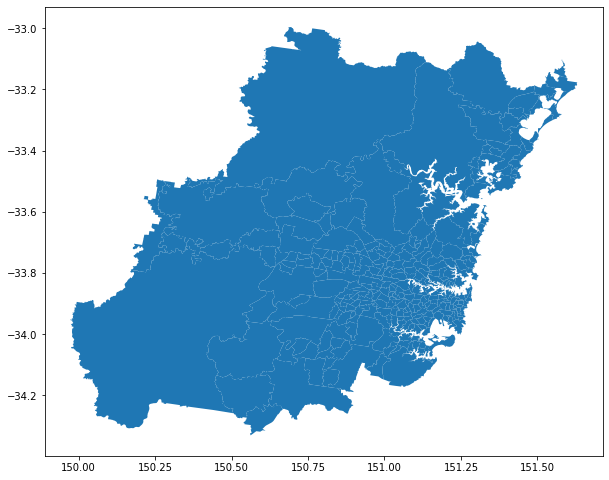

In [10]:
pgquery(conn, "SET search_path to covid, public")
query = """SELECT geom FROM neighbourhoods"""
neighbourhoods_map = gpd.read_postgis(query, conn)
neighbourhoods_map.plot(figsize=(10,10))

### Find health service density per neighbourhood

We did a spatial ST_Within join between Neighbourhoods and Health Services, thereby finding the health service density per neighbourhood, where neighbourhood is the neighbourhood population/1000.

In [11]:
query = """SELECT n.area_name, n.land_area, n.population, count(h.name) AS number_health_services,
			 count(h.name)/(n.population::float/1000) AS "healthservice_density", n.geom
             FROM neighbourhoods n JOIN health_services h ON (ST_Within(h.geom, n.geom))
             GROUP BY n.area_name, n.land_area, n.population, n.geom
             ORDER BY n.area_name ASC;
            """

healthservice_density = gpd.read_postgis(query, conn)
healthservice_density

,area_name,land_area,population,number_health_services,healthservice_density,geom
0,Arncliffe - Bardwell Valley,499.3,24873,8,0.321634,"MULTIPOLYGON (((151.13304 -33.93472, 151.13304..."
1,Ashcroft - Busby - Miller,546.3,17924,6,0.334747,"MULTIPOLYGON (((150.87516 -33.91086, 150.87518..."
2,Ashfield,367.0,26125,16,0.612440,"MULTIPOLYGON (((151.12086 -33.88102, 151.12115..."
3,Asquith - Mount Colah,3468.5,19107,8,0.418695,"MULTIPOLYGON (((151.08467 -33.65916, 151.08475..."
4,Auburn - Central,373.3,18575,15,0.807537,"MULTIPOLYGON (((151.01687 -33.84768, 151.01686..."
...,...,...,...,...,...,...
281,Woollahra,128.1,8246,4,0.485084,"MULTIPOLYGON (((151.23515 -33.88793, 151.23547..."
282,Woy Woy - Blackwall,1742.3,14327,3,0.209395,"MULTIPOLYGON (((151.31612 -33.48350, 151.31618..."
283,Wyoming,838.1,11659,8,0.686165,"MULTIPOLYGON (((151.34497 -33.39437, 151.34556..."
284,Wyong,1503.3,9114,3,0.329164,"MULTIPOLYGON (((151.41942 -33.26326, 151.42042..."


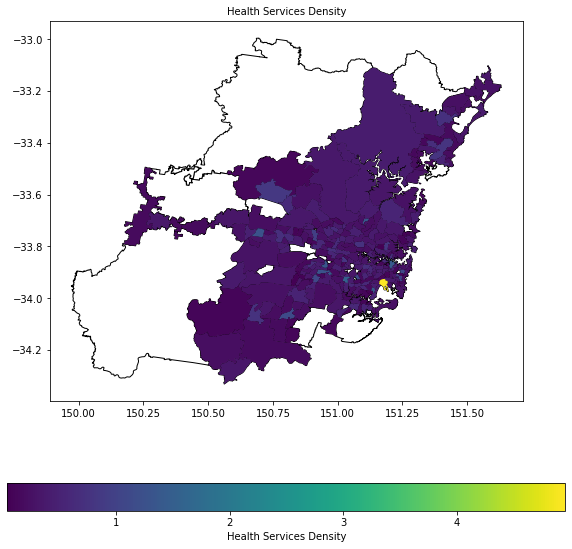

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Health Services Density", fontsize=10.0)
legend_kwds = {'label': "Health Services Density", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
healthservice_density.plot(column="healthservice_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### Find Population density per neighbourhood land area

In [18]:
query = """select area_name, population/land_area AS population_density, geom from neighbourhoods 
            ORDER BY population_density DESC;
            """

population_density = gpd.read_postgis(query,conn)
population_density

,area_name,population_density,geom
0,Holsworthy Military Area,NaN,"MULTIPOLYGON (((150.94079 -34.04003, 150.94089..."
1,Potts Point - Woolloomooloo,163.187114,"MULTIPOLYGON (((151.21886 -33.86862, 151.21897..."
2,Pyrmont - Ultimo,161.522468,"MULTIPOLYGON (((151.19359 -33.86437, 151.19376..."
3,Darlinghurst,144.854142,"MULTIPOLYGON (((151.21227 -33.87633, 151.21232..."
4,Surry Hills,137.264438,"MULTIPOLYGON (((151.20830 -33.88344, 151.20842..."
...,...,...,...
307,Bilpin - Colo - St Albans,0.012735,"MULTIPOLYGON (((150.97528 -33.36520, 150.97500..."
308,Rookwood Cemetery,0.009950,"MULTIPOLYGON (((151.05662 -33.86477, 151.05662..."
309,Royal National Park,0.002010,"MULTIPOLYGON (((151.07165 -34.05795, 151.07141..."
310,Blue Mountains - North,0.000218,"MULTIPOLYGON (((150.28661 -33.54050, 150.28766..."


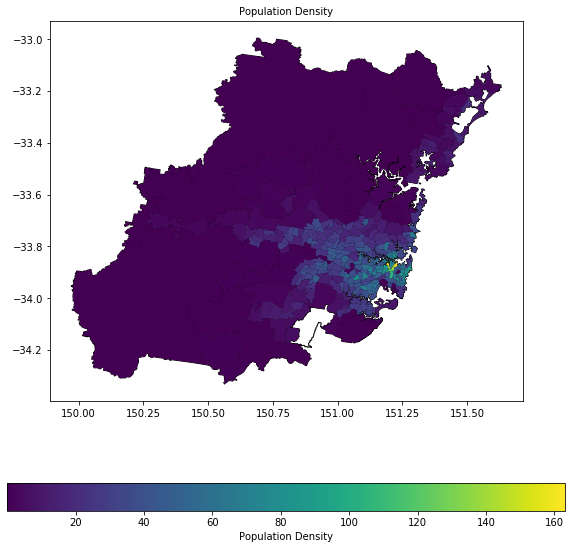

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Population Density", fontsize=10.0)
legend_kwds = {'label': "Population Density", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
population_density.plot(column="population_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### Find Population Age Percentage

In [21]:
query = """select area_name,CASE
WHEN total_persons = NULL OR total_persons = 0 Then NULL
ELSE 100*(age_70_to_74 + age_75_to_79 + age_80_to_84 + age_85_and_over)/total_persons::float 
END AS "Percentage_of_population_age_70_over", geom
from population_stats_2016 p LEFT JOIN sa2_data s ON (p.area_id = s.id);"""

population_age = gpd.read_postgis(query,conn)
population_age

,area_name,Percentage_of_population_age_70_over,geom
0,Braidwood,14.068441,"MULTIPOLYGON (((149.58423 -35.44427, 149.58444..."
1,Karabar,7.858387,"MULTIPOLYGON (((149.21898 -35.36739, 149.21799..."
2,Queanbeyan,10.467290,"MULTIPOLYGON (((149.21325 -35.34325, 149.21619..."
3,Queanbeyan - East,6.872648,"MULTIPOLYGON (((149.24033 -35.34782, 149.24023..."
4,Queanbeyan Region,5.873243,"MULTIPOLYGON (((149.23580 -35.38738, 149.23771..."
...,...,...,...
571,Royal National Park,0.000000,"MULTIPOLYGON (((151.07165 -34.05795, 151.07141..."
572,Sutherland - Kirrawee,12.474999,"MULTIPOLYGON (((151.05049 -34.02006, 151.05098..."
573,Engadine,10.777791,"MULTIPOLYGON (((150.99568 -34.05362, 150.99569..."
574,Loftus - Yarrawarrah,10.517821,"MULTIPOLYGON (((151.03954 -34.04176, 151.03954..."


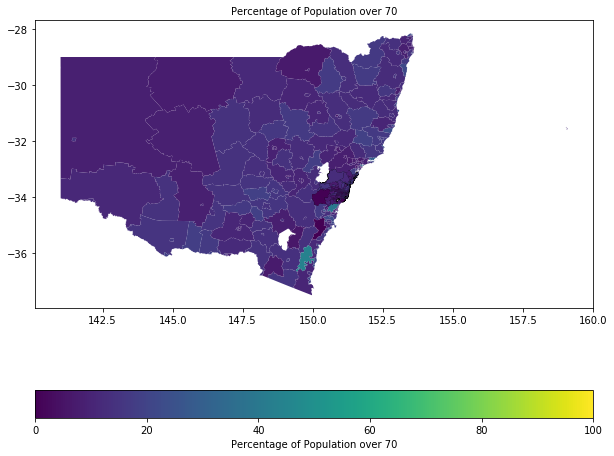

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Percentage of Population over 70", fontsize=10.0)
legend_kwds = {'label': "Percentage of Population over 70", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
population_age.plot(column="Percentage_of_population_age_70_over", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### Find hospital bed density

In [24]:
query = """SELECT n.area_name, SUM(h.num_beds)/(n.population/1000) AS "num_beds_density", n.geom
             FROM neighbourhoods n JOIN health_services h ON (ST_Within(h.geom, n.geom)) 
			 GROUP BY n.area_name,n.population,n.geom
			 ORDER BY num_beds_density DESC NULLS LAST;"""

hospital_bed_density = gpd.read_postgis(query,conn)
hospital_bed_density

,area_name,num_beds_density,geom
0,St Leonards - Naremburn,66.0,"MULTIPOLYGON (((151.17861 -33.81633, 151.17852..."
1,Northmead,61.0,"MULTIPOLYGON (((150.98516 -33.79340, 150.98532..."
2,Kogarah,61.0,"MULTIPOLYGON (((151.13299 -33.96108, 151.13305..."
3,Liverpool,54.0,"MULTIPOLYGON (((150.90541 -33.91768, 150.90539..."
4,Randwick - South,53.0,"MULTIPOLYGON (((151.23478 -33.91627, 151.23455..."
...,...,...,...
281,Canley Vale - Canley Heights,NaN,"MULTIPOLYGON (((150.91140 -33.88428, 150.91161..."
282,Canterbury (North) - Ashbury,NaN,"MULTIPOLYGON (((151.11531 -33.91001, 151.11552..."
283,Carlingford,NaN,"MULTIPOLYGON (((151.04140 -33.75981, 151.04181..."
284,Castle Hill - Central,NaN,"MULTIPOLYGON (((150.97343 -33.73437, 150.97332..."


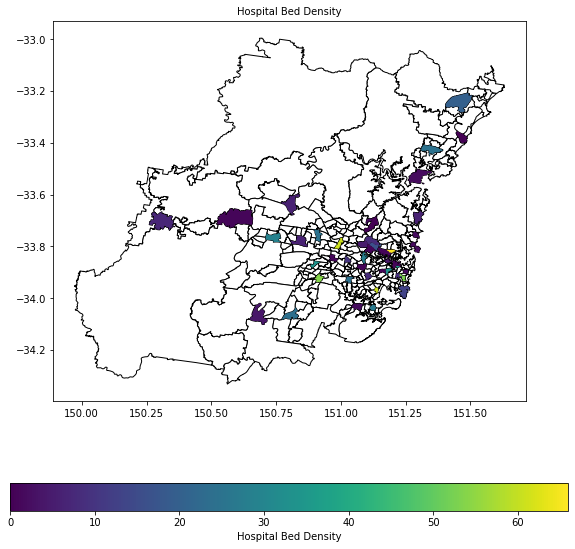

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Hospital Bed Density", fontsize=10.0)
legend_kwds = {'label': "Hospital Bed Density", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
hospital_bed_density.plot(column="num_beds_density", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### Find Covid tests per neighbourhood

In [26]:
query = """select neigh.area_name, count(ct.result) AS total_number_of_tests, neigh.geom FROM covid_tests ct 
JOIN nsw_postcodes np ON (ct.postcode = np.postcode) 
JOIN neighbourhoods neigh ON (ST_WITHIN(np.geom,neigh.geom))
GROUP BY neigh.area_name,neigh.geom 
ORDER BY total_number_of_tests DESC;"""

covid_tests = gpd.read_postgis(query,conn)
covid_tests

,area_name,total_number_of_tests,geom
0,Calga - Kulnura,7458,"MULTIPOLYGON (((151.20460 -33.53298, 151.20456..."
1,Douglas Park - Appin,5213,"MULTIPOLYGON (((150.63850 -34.17142, 150.64006..."
2,Jilliby - Yarramalong,5031,"MULTIPOLYGON (((151.22380 -33.18593, 151.22478..."
3,Lane Cove - Greenwich,4746,"MULTIPOLYGON (((151.14524 -33.81586, 151.14526..."
4,The Oaks - Oakdale,4370,"MULTIPOLYGON (((150.42301 -34.04533, 150.42298..."
...,...,...,...
194,Budgewoi - Buff Point - Halekulani,34,"MULTIPOLYGON (((151.55449 -33.22373, 151.55446..."
195,Warragamba - Silverdale,32,"MULTIPOLYGON (((150.58005 -33.89334, 150.58846..."
196,Bargo,27,"MULTIPOLYGON (((150.54883 -34.27732, 150.54889..."
197,Wentworth Falls,25,"MULTIPOLYGON (((150.35207 -33.70870, 150.35176..."


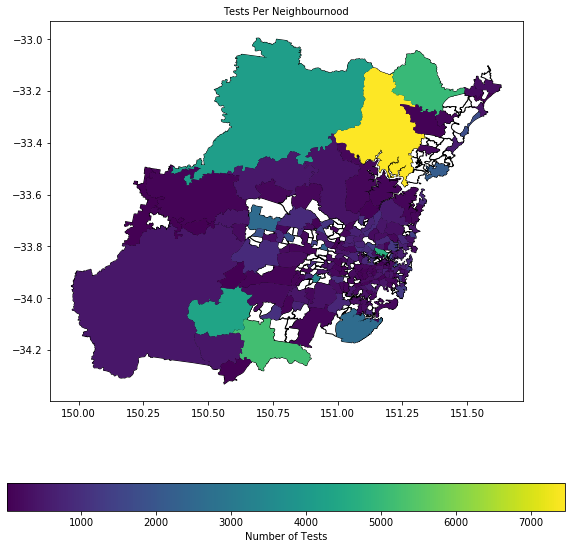

In [27]:
#Plotting map of tests conducted 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Tests Per Neighbournood", fontsize=10.0)
legend_kwds = {'label': "Number of Tests", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
covid_tests.plot(column="total_number_of_tests", figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

### Creating joint dataframe of the values

In [29]:
new_df_1 = pd.DataFrame(population_density, columns = ['area_name', 'population_density'])
new_df_2 = pd.DataFrame(population_age, columns = ['area_name', 'Percentage_of_population_age_70_over'])
new_df_3 = pd.DataFrame(healthservice_density, columns = ['area_name',  'healthservice_density'])
new_df_4 = pd.DataFrame(hospital_bed_density, columns = ['area_name', 'num_beds_density'])
new_df_5 = pd.DataFrame(covid_tests, columns = ['area_name',  'total_number_of_tests','geom'])

df_final = pd.merge(new_df_1, new_df_2, on='area_name')
df_final = pd.merge(df_final, new_df_3, on='area_name')
df_final = pd.merge(df_final, new_df_4, on='area_name')
df_final = pd.merge(df_final, new_df_5, on='area_name')


# Calculate averages and standard deviations
avg_series_across_columns = df_final.mean(axis=0)
std_series_across_columns = df_final.std(axis=0,ddof=0)

def z_score(cur_value, column):
    score = (cur_value - avg_series_across_columns[column])/std_series_across_columns[column]
    if cur_value is None or math.isnan(score):
        return 0
    else:
        return score

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

vulnerability_column = []

for index, cur_row in df_final.iterrows():    
    total_z_scores = (z_score(cur_row['population_density'], 'population_density') + z_score(cur_row['Percentage_of_population_age_70_over'], 'Percentage_of_population_age_70_over') + z_score(cur_row['healthservice_density'], 'healthservice_density') + z_score(cur_row['num_beds_density'], 'num_beds_density') + z_score(cur_row['total_number_of_tests'], 'total_number_of_tests'))
    vulnerability_column.append(sigmoid(total_z_scores))

df_final['Vulnerability'] = vulnerability_column
df_final = GeoDataFrame(df_final, geometry = 'geom')
df_final

,area_name,population_density,Percentage_of_population_age_70_over,healthservice_density,num_beds_density,total_number_of_tests,geom,Vulnerability
0,Potts Point - Woolloomooloo,163.187114,7.916485,0.462010,0.0,1644,"MULTIPOLYGON (((151.21886 -33.86862, 151.21897...",0.991765
1,Pyrmont - Ultimo,161.522468,4.258966,0.166092,NaN,214,"MULTIPOLYGON (((151.19359 -33.86437, 151.19376...",0.894793
2,Surry Hills,137.264438,6.355077,0.498229,NaN,897,"MULTIPOLYGON (((151.20830 -33.88344, 151.20842...",0.969565
3,Redfern - Chippendale,118.067499,5.523196,0.391573,NaN,108,"MULTIPOLYGON (((151.19681 -33.89074, 151.19686...",0.798993
4,Waterloo - Beaconsfield,105.917342,5.330804,0.263651,NaN,438,"MULTIPOLYGON (((151.20258 -33.90454, 151.20249...",0.721073
...,...,...,...,...,...,...,...,...
184,Douglas Park - Appin,0.361033,7.621432,0.191058,NaN,5213,"MULTIPOLYGON (((150.63850 -34.17142, 150.64006...",0.954446
185,The Oaks - Oakdale,0.290920,6.898048,0.106508,NaN,4370,"MULTIPOLYGON (((150.42301 -34.04533, 150.42298...",0.841847
186,Galston - Laughtondale,0.280544,15.006516,0.371885,NaN,150,"MULTIPOLYGON (((151.15204 -33.52771, 151.15204...",0.488226
187,Sydney Airport,0.226686,11.386139,4.950495,NaN,441,"MULTIPOLYGON (((151.16260 -33.93277, 151.16269...",0.999966


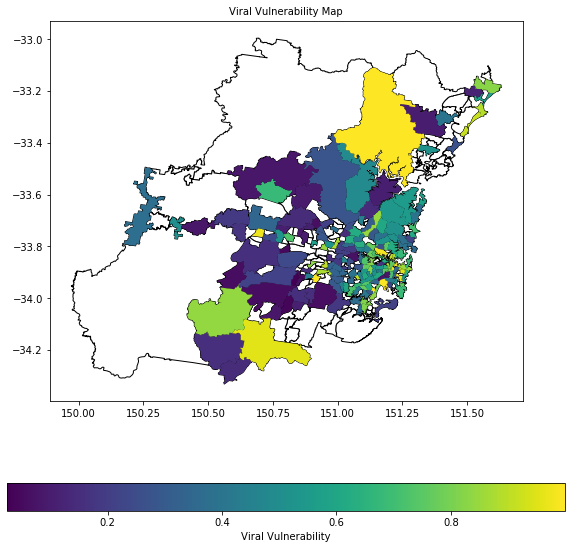

In [30]:
#Mapping the Viral Vulnerability 
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Viral Vulnerability Map", fontsize=10.0)
legend_kwds = {'label': "Viral Vulnerability", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
df_final.plot(column = 'Vulnerability', figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

In [ ]:
# Loading data into final_data_table
pgquery(conn, "DROP TABLE final_data")
final_data_table = """CREATE TABLE final_data (
               area_name VARCHAR(50),
               population_density NUMERIC,
               population_age_over_70 NUMERIC,
               healthservice_density NUMERIC,
               num_beds_density NUMERIC,
               total_number_of_tests INTEGER,
               geom GEOMETRY(MULTIPOLYGON,4326),
               viral_vulnerability NUMERIC
           );"""

pgquery(conn, "SET search_path to covid, public")
pgquery(conn, final_data_table)

geom_wkt_data = []
for index, row in df_final.iterrows():
    try:
        geom_wkt_data.append(row['geom'].wkt) # converting geometry polygon data to a string format
    except:
        geom_wkt_data.append(None)
df_final = df_final.assign(geom_wkt = geom_wkt_data) # adding string formatted geometry to dataframe

for index, row in df_final.iterrows():
    if str(row[1]) == "nan":
        row[1] = None
    if str(row[2]) == "nan":
        row[2] = None
    if str(row[3]) == "nan":
        row[3] = None
    if str(row[4]) == "nan":
        row[4] = None
    if str(row[5]) == "nan":
        row[5] = None
    if str(row[7]) == "nan":
        row[7] = None
    pgquery(conn, "INSERT INTO final_data VALUES (%s, %s, %s, %s, %s, %s, ST_Multi(ST_GeomFromText(%s, 4326)), %s)", (row[0], row[1], row[2], row[3], row[4], row[5], row[8], row[7]))

### Correlation

#### Viral Vulnerability vs Total Cases

In [31]:
query = """SELECT area_name, viral_vulnerability, total_cases, geom FROM final_data"""
total_cases_df = gpd.read_postgis(query, conn)
total_cases_df

,area_name,viral_vulnerability,total_cases,geom
0,Bondi - Tamarama - Bronte,0.663233,3,"MULTIPOLYGON (((151.25847 -33.89116, 151.25857..."
1,Lake Munmorah - Mannering Park,0.826019,0,"MULTIPOLYGON (((151.52887 -33.16344, 151.52861..."
2,Dural - Kenthurst - Wisemans Ferry,0.278259,3,"MULTIPOLYGON (((150.93443 -33.65021, 150.93450..."
3,The Oaks - Oakdale,0.841847,92,"MULTIPOLYGON (((150.42301 -34.04533, 150.42298..."
4,Picton - Tahmoor - Buxton,0.154794,0,"MULTIPOLYGON (((150.50394 -34.14676, 150.50508..."
...,...,...,...,...
184,Wentworth Falls,0.507758,0,"MULTIPOLYGON (((150.35207 -33.70870, 150.35176..."
185,Holsworthy - Wattle Grove,0.061756,0,"MULTIPOLYGON (((150.91874 -33.94279, 150.91871..."
186,Lawson - Hazelbrook - Linden,0.083205,0,"MULTIPOLYGON (((150.50210 -33.71525, 150.50194..."
187,Tuggerah - Kangy Angy,0.399711,0,"MULTIPOLYGON (((151.46489 -33.30145, 151.46498..."


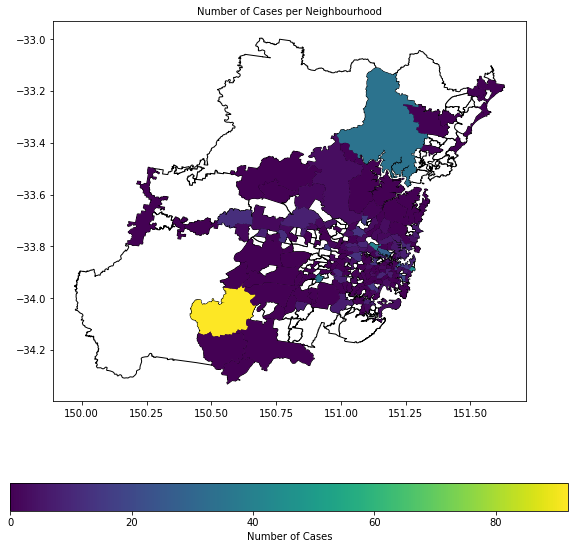

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Number of Cases per Neighbourhood", fontsize=10.0)
legend_kwds = {'label': "Number of Cases", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
total_cases_df.plot(column = 'total_cases', figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

Correlation: 0.8712073378365707


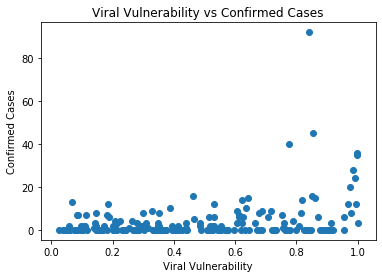

In [20]:
plt.scatter(total_cases_df['viral_vulnerability'], total_cases_df['total_cases'])
plt.xlabel("Viral Vulnerability")
plt.ylabel("Confirmed Cases")
plt.title("Viral Vulnerability vs Confirmed Cases")
print("Correlation: " + str(cov(total_cases_df['viral_vulnerability'], total_cases_df['total_cases'])[0][1]))

#### Viral Vulnerability vs Percentage of tests returned positive

In [33]:
query = """SELECT area_name, (total_cases::float/total_number_of_tests::float)*100 AS "Percentage tested positive", viral_vulnerability, geom 
            FROM final_data
            ORDER BY "Percentage tested positive" DESC """
perc_tested_positive = gpd.read_postgis(query, conn)
perc_tested_positive

,area_name,Percentage tested positive,viral_vulnerability,geom
0,Bass Hill - Georges Hall,5.325444,0.328026,"MULTIPOLYGON (((150.97517 -33.88607, 150.97578..."
1,Forestville - Killarney Heights,4.545455,0.513412,"MULTIPOLYGON (((151.19579 -33.75403, 151.19610..."
2,Ermington - Rydalmere,4.000000,0.187839,"MULTIPOLYGON (((151.06100 -33.79736, 151.06104..."
3,Sylvania - Taren Point,3.703704,0.815705,"MULTIPOLYGON (((151.09069 -34.01084, 151.09068..."
4,Parklea - Kellyville Ridge,3.636364,0.059021,"MULTIPOLYGON (((150.90404 -33.69834, 150.90360..."
...,...,...,...,...
184,Mount Druitt - Whalan,0.000000,0.730168,"MULTIPOLYGON (((150.79384 -33.75930, 150.79372..."
185,Padstow,0.000000,0.597483,"MULTIPOLYGON (((151.02139 -33.95521, 151.02134..."
186,Peakhurst - Lugarno,0.000000,0.727083,"MULTIPOLYGON (((151.04640 -33.96805, 151.04569..."
187,Hinchinbrook,0.000000,0.048176,"MULTIPOLYGON (((150.87376 -33.91086, 150.87465..."


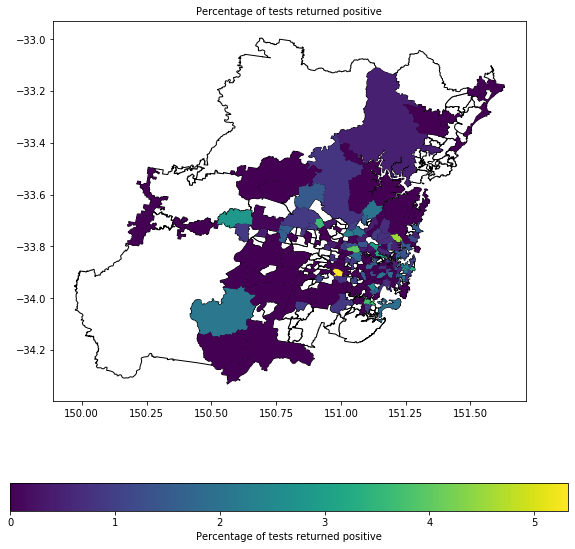

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Percentage of tests returned positive", fontsize=10.0)
legend_kwds = {'label': "Percentage of tests returned positive", 'orientation': "horizontal"}
neighbourhoods_map.plot(figsize=(10,10), ax=ax, color='white', edgecolor='black')
perc_tested_positive.plot(column = 'Percentage tested positive', figsize=(10, 10), ax=ax, legend=True, legend_kwds=legend_kwds)
plt.show()

Correlation: 0.032278784202117036


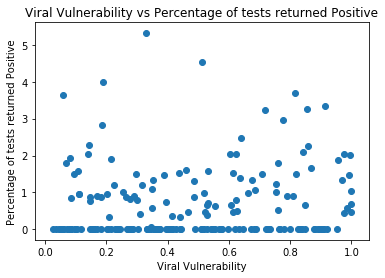

In [21]:
plt.scatter(perc_tested_positive['viral_vulnerability'], perc_tested_positive['Percentage tested positive'])
plt.xlabel("Viral Vulnerability")
plt.ylabel("Percentage of tests returned positive")
plt.title("Viral Vulnerability vs Percentage of tests returned positive")
print("Correlation: " + str(cov(perc_tested_positive['viral_vulnerability'], perc_tested_positive['Percentage tested positive'])[0][1]))

## Closing Connection

In [35]:
conn.close()